In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import IterableDataset, DataLoader
from matplotlib import pyplot as plt
from typing import Tuple, Optional, Any
import math
from torch import Tensor
from einops import rearrange
from diffusers import DDPMScheduler
from torchvision import transforms, datasets
from tqdm import tqdm
from IPython.display import clear_output
import einops
from torch.utils.data.dataset import Dataset
from dataclasses import dataclass
from typing import List, Union, Dict, Any, Optional, BinaryIO
from PIL import Image, ImageColor, ImageDraw, ImageFont, UnidentifiedImageError
import abc  # Abstract base class
import numpy as np
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import DDPMScheduler, DDPMPipeline
from diffusers.models.unets.unet_2d_condition import UNet2DConditionModel
from diffusers import DDPMScheduler, DDPMPipeline
from diffusers import DDPMScheduler, DDPMPipeline
from datasets import load_dataset
import requests
from io import BytesIO
from concurrent.futures import ThreadPoolExecutor, as_completed
import threading

c:\Users\Shlomi\AppData\Local\pypoetry\Cache\virtualenvs\text-conditioned-image-generation-using-st-35DVCAXA-py3.11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

INPUT_SIZE = 224

model = UNet2DConditionModel(
    sample_size=INPUT_SIZE,  # input resolution
    in_channels=1,  # latent channels (usually 4 if using VAE)
    out_channels=1,  # same as in_channels for DDPM
    down_block_types=[
        "CrossAttnDownBlock2D",  # uses text-conditioning attention
        "CrossAttnDownBlock2D",
        "CrossAttnDownBlock2D",
        "DownBlock2D",           # last block can omit attention
    ],
    up_block_types=[
        "UpBlock2D",
        "CrossAttnUpBlock2D",
        "CrossAttnUpBlock2D",
        "CrossAttnUpBlock2D",
    ],
    block_out_channels=[320, 640, 1280, 1280],  # Wide receptive fields and strong representations
    layers_per_block=2,
    cross_attention_dim=768,  # CLIP text embedding size (ViT-B/32)
    attention_head_dim=8,
    norm_num_groups=32
)
model = model.to(device)


In [3]:
# vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to(device)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

# Freeze VAE and text encoder
# vae.requires_grad_(False)
## set requires_grad_ to true so that the text_enocder aka CLIP model is also trained.
text_encoder.requires_grad_(False)
# tokenizer.requires_grad_(False)

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [4]:
TOKENIZER_MAX_LENGTH = 77
example_prompt = ["a photo of a golden retriever wearing sunglasses"]
text_input = tokenizer(example_prompt, padding="max_length", max_length=TOKENIZER_MAX_LENGTH, truncation=True, return_tensors="pt")
text_encoder(text_input.input_ids.to(device))[0].shape

## the following output is the size of the text embedding for one text prompt.

torch.Size([1, 77, 512])

In [5]:
num_of_params = sum([p.numel() for p in model.parameters()])
print("Number of trainable parameters in the model: " + str(f"{num_of_params:,}"))

Number of trainable parameters in the model: 859,503,681


# Color palette

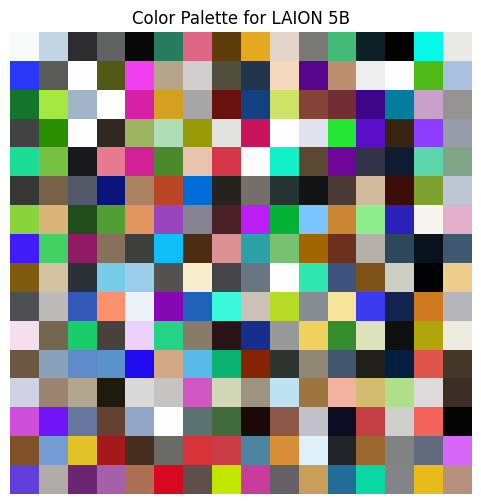

In [6]:
# Load color palette
palette = torch.tensor(np.load("../../color reduction palettes/laion5b_palette_8bit.npy"))

palette.shape# Ensure values are in [0, 1] for matplotlib

copy_palette = palette.clone()

if copy_palette.max() > 1.0:
    copy_palette = copy_palette / 255.0

# Compute size for square grid
num_colors = copy_palette.shape[0]
grid_size = int(math.ceil(math.sqrt(num_colors)))  # e.g., 23x23 for 512

# Pad if not a perfect square
padding = grid_size ** 2 - num_colors
if padding > 0:
    pad = torch.ones(padding, 3)  # white padding or change to zeros for black
    copy_palette = torch.cat([copy_palette, pad], dim=0)

# Reshape to [H, W, 3] for image plotting
palette_image = copy_palette.view(grid_size, grid_size, 3)

# Plot
plt.figure(figsize=(6, 6))
plt.imshow(palette_image)
plt.axis('off')
plt.title("Color Palette for LAION 5B")
plt.show()

In [7]:
def quantize_batch_to_palette_indices(images: torch.Tensor, palette: torch.Tensor) -> torch.Tensor:
    """
    Quantizes each pixel in the input batch to the nearest palette color index.

    Args:
        images: Tensor of shape [B, 3, H, W], uint8, values in [0, 255]
        palette: Tensor of shape [K, 3], uint8, values in [0, 255]
        k: Number of colors in the palette

    Returns:
        Tensor of shape [B, H, W], with palette indices (0 to K-1) as int64
    """
    assert images.shape[1] == 3, "Images must be RGB"
    B, C, H, W = images.shape

    pixels = images.permute(0, 2, 3, 1).reshape(-1, 3).float()  # [B*H*W, 3]
    palette = palette.float()  # [K, 3]

    dists = torch.cdist(pixels, palette)  # [B*H*W, K]
    nearest_idx = torch.argmin(dists, dim=1)  # [B*H*W]

    indices = nearest_idx.reshape(B, H, W)  # [B, H, W]

    assert indices.min() >= 0 and indices.max() < 2 ** 8, "Indices must be in range [0, K-1]"
    indices = indices.to(torch.uint8)
    return indices

def reconstruct_from_indices(indices: torch.Tensor, palette: torch.Tensor) -> torch.Tensor:
    """
    Converts quantized palette indices [B, H, W] back to RGB images using the palette [K, 3].

    Args:
        indices: Tensor of shape [B, H, W], dtype uint8 or long
        palette: Tensor of shape [K, 3], dtype uint8

    Returns:
        Tensor of shape [B, 3, H, W], dtype uint8
    """
    assert indices.dim() == 3, "Expected shape [B, H, W]"
    assert palette.dim() == 2 and palette.shape[1] == 3, "Expected palette shape [K, 3]"

    B, H, W = indices.shape
    flat_indices = indices.reshape(-1).long()  # ensure type is long
    palette = palette.to(indices.device)       # move to same device

    # Lookup RGB colors
    rgb = palette[flat_indices]  # [B*H*W, 3]

    # Reshape back to [B, 3, H, W]
    rgb = rgb.reshape(B, H, W, 3).permute(0, 3, 1, 2).contiguous()
    return rgb



# Dataset, dataloader, transforms, noise sched

In [8]:
class LaionStreamDataset(IterableDataset):
    """
    Streaming dataset. Stores a buffer of images and captions for next batch use.
    - max_items: The maximum items to store in the buffer (image, caption). Sometimes the buffer can go beyond that for performance reasons and threading, but we try to keep it to this length.
    """
    def __init__(self, transform, max_items=64, num_threads=8):
        self.dataset = load_dataset("laion/laion2B-en", streaming=True, split="train")
        self.transform = transform
        self.max_items = max_items
        self.num_threads = num_threads
        self.buffer = []

        # Shared counters
        self.lock = threading.Lock()
        self.valid_images = 0
        self.invalid_images = 0

    def download_and_process(self, example: dict) -> Tuple[Any, str]:
        """
        Given a dataset item (with URL and caption), downloads and returns the image and caption.
        Returns None on failure.
        """
        try:
            url = example["url"]
            caption = example["caption"]

            response = requests.get(url, timeout=5, stream=True)
            if response.status_code != 200 or "image" not in response.headers.get("Content-Type", ""):
                with self.lock:
                    self.invalid_images += 1
                return None

            try:
                image = Image.open(BytesIO(response.content))
                image.verify()
                image = Image.open(BytesIO(response.content)).convert("RGB")
            except (UnidentifiedImageError, OSError):
                with self.lock:
                    self.invalid_images += 1
                return None

            if self.transform:
                image = self.transform(image)
            
            with self.lock:
                self.valid_images += 1

            return image, caption

        except Exception:
            with self.lock:
                self.invalid_images += 1
            return None

    def __iter__(self):
        data_iter = iter(self.dataset)

        def fill_buffer():
            """
            Fills the buffer up to max_items using threading.
            """
            needed = self.max_items - len(self.buffer)
            if needed <= 0:
                return

            examples = []
            for _ in range(needed * 2):  # Grab more to account for failures
                try:
                    examples.append(next(data_iter))
                except StopIteration:
                    break

            with ThreadPoolExecutor(max_workers=self.num_threads) as executor:
                futures = [executor.submit(self.download_and_process, ex) for ex in examples]
                for future in as_completed(futures):
                    result = future.result()
                    if result is not None:
                        self.buffer.append(result)
                        if len(self.buffer) >= self.max_items:
                            break

            # if len(self.buffer) < self.max_items:
            #   print(f"[Warning] Buffer only filled to {len(self.buffer)} of {self.max_items} due to image download failures.")

        # Initial fill
        fill_buffer()

        while True:
            # Refill if buffer is low
            if len(self.buffer) < self.max_items // 2:
                fill_buffer()

            if not self.buffer:
                break  # Nothing more to yield

            yield self.buffer.pop(0)

        # print(f"\nFinished streaming:")
        # print(f"✅ Valid images:     {self.valid_images}")
        # print(f"❌ Invalid images:   {self.invalid_images}")

In [9]:
BATCH_SIZE = 64

class ToUint8:
    def __call__(self, image: torch.Tensor) -> torch.Tensor:
        return (image * 255).clamp(0, 255).to(torch.uint8)

image_transform = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.ToTensor(),
    ToUint8(), # for quantization
])

noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")

dataset = LaionStreamDataset(transform=image_transform, max_items=BATCH_SIZE, num_threads=64)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)

In [10]:
img, caption = next(iter(dataset))
img = img.unsqueeze(0)
img = quantize_batch_to_palette_indices(img, palette)
print(img.min(), img.max(), img.shape)
c, h, w = img.shape
assert c == 1 and h == INPUT_SIZE and w == INPUT_SIZE

c:\Users\Shlomi\AppData\Local\pypoetry\Cache\virtualenvs\text-conditioned-image-generation-using-st-35DVCAXA-py3.11\Lib\site-packages\PIL\Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8) torch.Size([1, 224, 224])


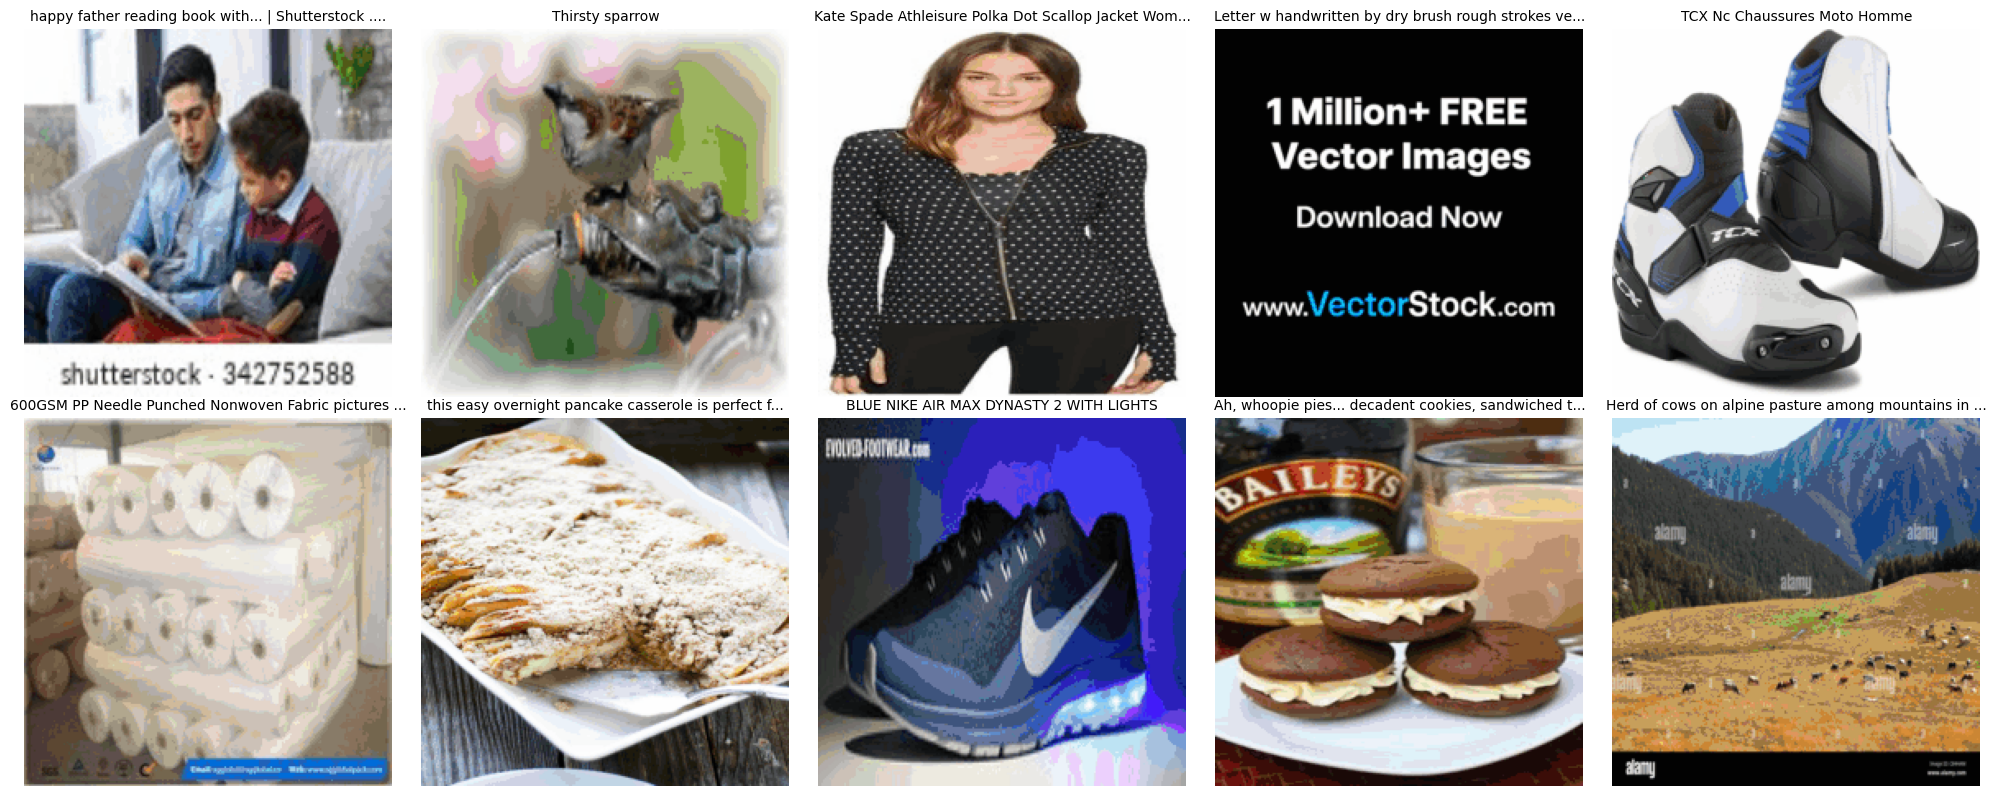

In [11]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

count = 0
for image, caption in dataset:
    # quantize batch of size 1
    image = image.unsqueeze(0)
    image = quantize_batch_to_palette_indices(image, palette)

    # reconstruct
    image = reconstruct_from_indices(image, palette)
    image = image.squeeze(0)

    image = rearrange(image, "c h w -> h w c")

    axes[count].imshow(image)
    axes[count].set_title(caption[:50] + "..." if len(caption) > 50 else caption, fontsize=10)
    axes[count].axis("off")

    count += 1
    if count == 10:
        break

plt.tight_layout()
plt.show()

In [12]:
def plot_image_batch(images: torch.Tensor, captions, max_images=8):
    """
    Plot a batch of images with shape [B, C, H, W].

    Args:
        images (torch.Tensor): Tensor of shape [B, C, H, W].
        titles (list of str, optional): Optional list of titles for each image.
        max_images (int): Max number of images to plot.
    """
    B, C, H, W = images.shape
    assert C in [1, 3], f"Expected 1 or 3 channels, got {C}"

    num_to_plot = min(B, max_images)
    fig, axes = plt.subplots(1, num_to_plot, figsize=(4 * num_to_plot, 4))

    if num_to_plot == 1:
        axes = [axes]

    for i in range(num_to_plot):
        img = images[i]

        # Convert to [H, W, C] for plotting
        if C == 1:
            img_np = img.squeeze(0).cpu().numpy()  # [H, W]
            axes[i].imshow(img_np, cmap='gray')
        else:
            if img.dtype == torch.float:
                img = (img * 255).clamp(0, 255).to(torch.uint8)
            img_np = rearrange(img, "c h w -> h w c").cpu().numpy()
            axes[i].imshow(img_np)

        axes[i].set_title(captions[i], fontsize=10)

        axes[i].axis("off")

    plt.tight_layout()
    plt.show()


Epoch 1/1: 0it [00:00, ?it/s]

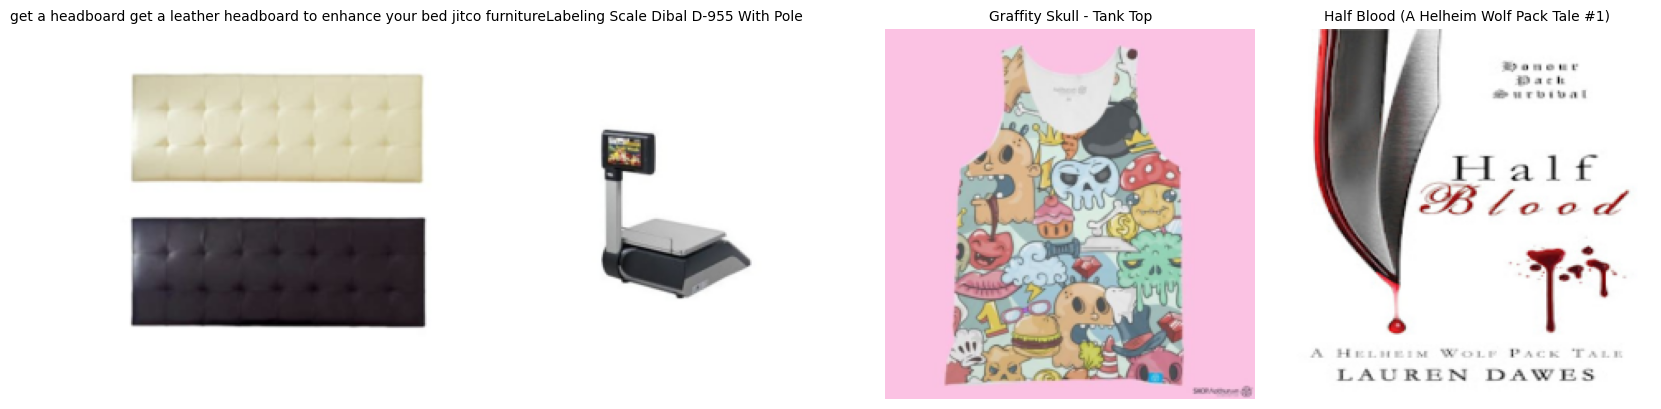

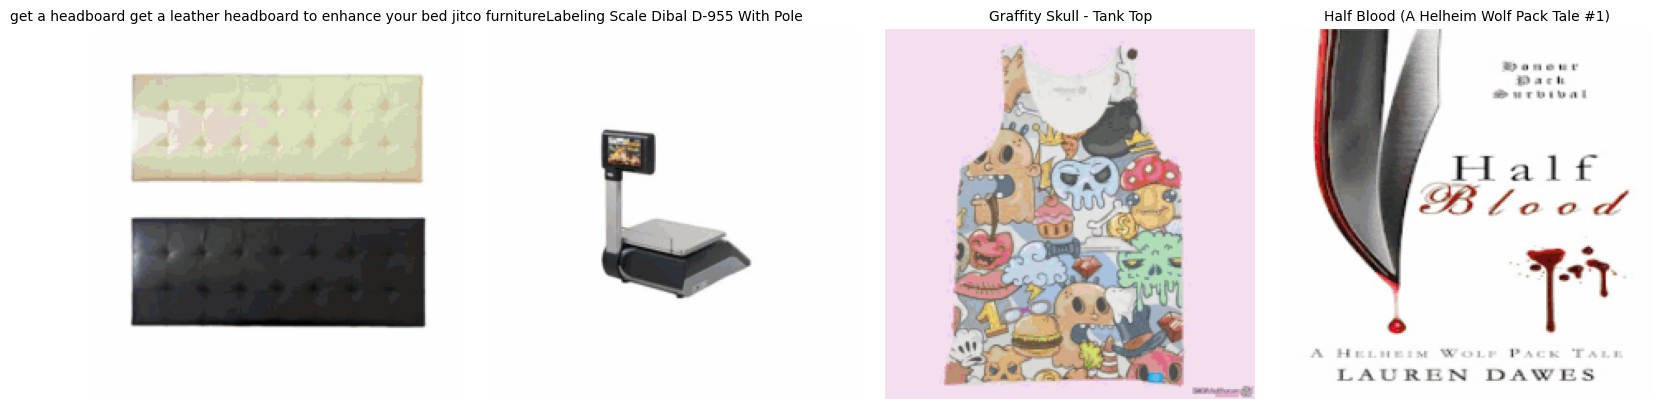

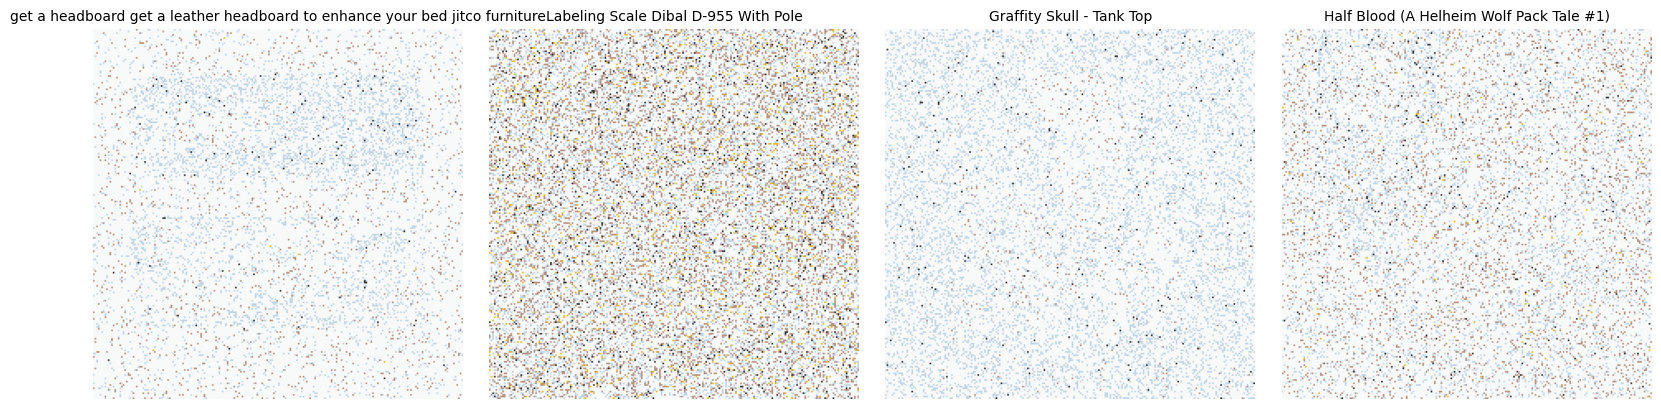

In [ ]:
# Training parameters
# num_epochs = 100
num_epochs = 1
# learning_rate = 1e-4
learning_rate = 1e-3
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
steps= 0

total_images_processed = 0

# Training loop
for epoch in range(num_epochs):
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", dynamic_ncols=True)

    for batch in pbar:
        images, captions = batch # [B, 3, H, W]
        b, _, _, _ = images.shape

        plot_image_batch(images, captions, 4)

        # quantize
        images = quantize_batch_to_palette_indices(images, palette)
        images = images.unsqueeze(1).to(device) # [B, 1, H, W]

        # plot quantized images
        rec_images = reconstruct_from_indices(images.squeeze(1), palette)
        plot_image_batch(rec_images, captions, 4)

        # Encode text
        text_input = tokenizer(captions, padding="max_length", max_length=TOKENIZER_MAX_LENGTH, truncation=True, return_tensors="pt")
        text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

        # Convert to float32 for noise addition
        images = images.float() / 255.0  # Or normalize as needed

        # Add noise to latents
        noise = torch.randn_like(images)
        timesteps = torch.randint(0, 1000, (images.shape[0],), device=device).long()
        noisy_latents = noise_scheduler.add_noise(images, noise, timesteps)

        # plot noisy images
        rec_noisy = reconstruct_from_indices(noisy_latents.squeeze(1), palette)
        plot_image_batch(rec_noisy, captions, 4)

        # Predict noise
        noise_pred = model(noisy_latents, timesteps, encoder_hidden_states=text_embeddings).sample
        print("predicted noise")

        # Calculate loss
        loss = torch.nn.functional.mse_loss(noise_pred, noise)

        # Backpropagate and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Update tracking
        total_images_processed += b
        steps += 1
        pbar.set_postfix({
            "Loss": f"{loss.item():.4f}",
            "Total Images": total_images_processed,
            "Steps": steps
        })

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

In [ ]:
# Set models to evaluation mode
# vae.eval()
text_encoder.eval()
model.eval()

# Inference parameters
num_inference_steps = 50
# guidance_scale = 100

@torch.no_grad()
def generate_image(prompt):
    # Tokenize and encode the text prompt
    text_input = tokenizer(prompt, padding="max_length", max_length=TOKENIZER_MAX_LENGTH, truncation=True, return_tensors="pt")
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

    # Initialize latents / create noisy image.
    torch.manual_seed(422)  # Set the seed
    latents = torch.randn((1, model.in_channels, 28, 28)).to(device)

    # Denoise scheduler
    scheduler = DDPMScheduler(beta_schedule="squaredcos_cap_v2", num_train_timesteps=1000)
    scheduler.set_timesteps(num_inference_steps)

    # Denoising loop
    for t in tqdm(scheduler.timesteps):
        # Prepare latent model input
        latent_model_input = scheduler.scale_model_input(latents, t)

        # Predict noise residual
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # Compute previous noisy sample
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    # # Decode latents to image
    # latents = 1 / 0.18215 * latents
    # image = vae.decode(latents).sample
    image=latents
    print (image.shape)
    # Post-process image ## i.e reverse the normalization
    image = (image / 2 + 0.5).clamp(0, 1)
    # image = image.cpu().permute(0, 2, 3, 1).numpy()
    # image = (image * 255).round().astype("uint8")
    return image

# Generate an image
prompt = "A handwritten digit 4"
generated_image = generate_image(prompt)

# Display or save the image
image = generated_image[0]  # Remove the extra dimension
image = image.squeeze(0)
image = image.detach().cpu().numpy()  # Remove batch dimension
# image = image.unsqueeze(-1)  # Add a new dimension for color channels
image = (image * 255).round().astype("uint8")
import matplotlib.pyplot as plt

# Assuming generated_image is the tensor you want to view
# image = generated_image[0].detach().cpu().numpy()  # Remove batch dimension
# image = image.unsqueeze(-1)  # Add a new dimension for color channels
plt.imshow(image, cmap='gray')  # Display as grayscale image
plt.show()

In [ ]:
## save unet and text_encoder
# Save the trained model
# torch.save(unet.state_dict(), "./unet.pth")


In [ ]:
# Set models to evaluation mode
# vae.eval()
# text_encoder.eval()
unet.eval()

# Inference parameters
num_inference_steps = 50
guidance_scale = 8

@torch.no_grad()
def generate_image(prompt, num_images=1):
    # Tokenize and encode the text prompt
    text_input = tokenizer(prompt, padding="max_length", max_length=TOKENIZER_MAX_LENGTH, truncation=True, return_tensors="pt")
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

    # Prepare unconditioned embeddings for classifier free guidance
    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer([""] * num_images, padding="max_length", max_length=TOKENIZER_MAX_LENGTH, return_tensors="pt")
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

    # Concatenate text embeddings with unconditional embeddings
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Initialize latents
    latents = torch.randn((num_images, unet.in_channels, 28, 28)).to(device)

    # Denoise scheduler
    scheduler = DDPMScheduler(beta_schedule="squaredcos_cap_v2", num_train_timesteps=1000)
    scheduler.set_timesteps(num_inference_steps)

    for t in tqdm(scheduler.timesteps):
        # Expand latents for classifier free guidance
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)
        # Predict noise residual
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # Perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # Compute previous noisy sample
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    # # Decode latents to image
    # latents = 1 / 0.18215 * latents
    # image = vae.decode(latents).sample
    image=latents
    print (image.shape)
    # Post-process image
    image = (image / 2 + 0.5).clamp(0, 1)
    # image = image.cpu().permute(0, 2, 3, 1).numpy()
    # image = (image * 255).round().astype("uint8")
    return image

# Generate an image
prompt = "A handwritten digit 5"
generated_images = generate_image(prompt)

# Display or save the image
image = generated_images[0]  # Remove the extra dimension
image = image.squeeze(0)
image = image.detach().cpu().numpy()  # Remove batch dimension
# image = image.unsqueeze(-1)  # Add a new dimension for color channels
image = (image * 255).round().astype("uint8")
import matplotlib.pyplot as plt

# Assuming generated_image is the tensor you want to view
# image = generated_image[0].detach().cpu().numpy()  # Remove batch dimension
# image = image.unsqueeze(-1)  # Add a new dimension for color channels
plt.imshow(image, cmap='gray')  # Display as grayscale image
plt.show()


In [ ]:
# Define the guidance scale values
guidance_scales = [0, 5, 10, 20, 50, 100]

# Initialize a figure with a grid of subplots
fig, axs = plt.subplots(nrows=1, ncols=len(guidance_scales), figsize=(20, 4))

# Generate an image for each guidance scale value
for i, guidance_scale in enumerate(guidance_scales):
    # Set the guidance scale
    # global guidance_scale
    # guidance_scale = guidance_scale

    # Generate an image
    prompt = "A handwritten digit 0"
    generated_image = generate_image(prompt)

    # Display or save the image
    image = generated_image[0]  # Remove the extra dimension
    image = image.squeeze(0)
    image = image.detach().cpu().numpy()  # Remove batch dimension
    image = (image * 255).round().astype("uint8")

    # Display the image in the current subplot
    axs[i].imshow(image, cmap='gray')  # Display as grayscale image
    axs[i].set_title(f'Guidance Scale: {guidance_scale}')
    axs[i].axis('off')

# Layout so plots do not overlap
fig.tight_layout()

# Display the plot
plt.show()